<a href="https://colab.research.google.com/github/avilaJorge/CSE253_FinalProject/blob/master/DeepFakeDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp *.py /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles
!cp *.ipynb /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles

In [0]:
# !wget https://storage.googleapis.com/img-hosting-bucket/Faces_HQ.hdf5

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 11 02:09:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%run DeepFake_Dataloader.py
%run utils.py

In [0]:
# imports pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Numpy, Matplotlib, and PIL
import numpy as np
import matplotlib.pyplot as plt

# general imports
import pprint

# My imports
from DeepFake_Dataloader import get_dataloaders
from models import LinearRegression, save_model
from utils import RunningAverage

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
trn_dl, val_dl, tst_dl = get_dataloaders()

In [0]:
s_epoch      = 1
num_epochs   = 2
log_step     = 10e5
lr_rate      = 1e-5
best_loss    = float('inf')
prev_loss    = float('inf')
loss_inc_cnt = 0
stp_erly_cnt = 4
stop_early   = False
load_model   = False
model_name   = 'LogisticRegressionModel'

def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight)
        m.bias.data.fill_(0.01)
        print(m.weight)

lr_model = LinearRegression(725, 1500, 250).to(device)
lr_model.apply(init_weights)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=lr_rate, weight_decay=1e-4, momentum=0.5)

if load_model:
    lr_model.load_state_dict(torch.load(''))

Linear(in_features=725, out_features=1, bias=True)
Parameter containing:
tensor([[0.6141, 0.1208, 0.7905, 0.3305, 0.8437, 0.6903, 0.1215, 0.8346, 0.6085,
         0.9663, 0.9441, 0.0507, 0.9795, 0.4080, 0.7033, 0.3383, 0.9272, 0.0550,
         0.8600, 0.1916, 0.4667, 0.2681, 0.2737, 0.8424, 0.3517, 0.5090, 0.8379,
         0.1328, 0.9045, 0.6773, 0.3042, 0.4186, 0.4851, 0.3589, 0.0384, 0.7386,
         0.5644, 0.5452, 0.0813, 0.7776, 0.7358, 0.6568, 0.2130, 0.8691, 0.0396,
         0.7617, 0.3941, 0.0493, 0.9321, 0.3963, 0.7661, 0.6927, 0.6775, 0.5211,
         0.7713, 0.6862, 0.7125, 0.3725, 0.3287, 0.6414, 0.0355, 0.7629, 0.0801,
         0.8084, 0.1015, 0.5834, 0.0332, 0.7827, 0.1283, 0.3496, 0.0841, 0.0862,
         0.6483, 0.5701, 0.3210, 0.6089, 0.6980, 0.0981, 0.1443, 0.4856, 0.5231,
         0.7744, 0.5801, 0.5399, 0.8192, 0.2861, 0.3974, 0.9032, 0.2973, 0.6263,
         0.0651, 0.4803, 0.6595, 0.6460, 0.3849, 0.4826, 0.0924, 0.7951, 0.2386,
         0.9615, 0.8420, 0.5725, 0.2

In [0]:
def train(model, dataloader, validation_loader):
    
    train_losses = []
    valid_losses = []
    
    # Train the models
    total_step = len(dataloader.dataset)
    for epoch in range(s_epoch, num_epochs):
        
        # create a progress bar
        progress = ProgressMonitor(length=total_step)
                                   
        train_loss = MovingAverage()
        
        for i, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Move to GPU
            x = check_dims(x).to(device)
            y = y.to(device)
            print("x.shape=", x.shape)
            print("y.shape=", y.shape)
            print(x[0])
            # Forward, backward and optimize
            pred = model(x)
            print("pred.shape=", pred.shape)
            print(pred)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            loss=loss.item()
                                   
            # update average loss
            train_loss.update(loss)

            # update progress bar
            progress.update(x.shape[0], train_loss)
        print("Prediction Size: ", pred.shape)
        print('Epoch: ', epoch)
        print('Training loss:', train_loss)
        train_losses.append(train_loss.value)
        evaluate(model, epoch, validation_loader, valid_losses)
        if stop_early:
            break
    
    return train_losses, valid_losses

def evaluate(model, epoch, data_loader, valid_losses, validation=True):

    global best_loss
    global prev_loss
    global loss_inc_cnt
    global stop_early
                            

    # keep track of predictions
    y_predics = []
    y_targets = []
    
    with torch.no_grad():
                            
        total_step = len(data_loader.dataset)
        
        # create a progress bar
        progress = ProgressMonitor(length=total_step)
        
        losses = RunningAverage()
        
        for i, (x, y) in enumerate(data_loader):

            # Move to GPU
            x = check_dims(x).to(device)
            y = y.to(device)

            # Evaluate
            pred = model(x)
            
            loss = criterion(pred, y).item()
                            
            losses.update(loss)
            y_predics.extend((pred > 0.5).float())
            y_targets.extend(y)
            
            # update progress bar
            progress.update(x.shape[0], losses)
                            
                                   
        
        loss = losses.value
        print("Validation Loss: ", losses)
        valid_losses.append(losses.value)

        # Calculate validation accuracy
        y_pred = torch.tensor(y_predics, dtype=torch.int64)
        y_targ = torch.tensor(y_targets, dtype=torch.int64)
        accuracy = torch.mean((y_pred == y_targ).float())
        print('Validation accuracy: {:.4f}%'.format(float(accuracy) * 100))

        if validation:
            if best_loss > loss:
                best_loss = loss
                print('"Best Loss": ' + str(best_loss) + '\n')
                save_model(model, 'Best-' + model_name, dt, path)

            loss_inc_cnt = loss_inc_cnt + 1 if prev_loss < loss else 0
            if loss_inc_cnt > 2: stop_early = True
            save_model(model, model_name, dt, path)
            print("Validation Loss has gone up %d times.\n" % (loss_inc_cnt))
            prev_loss = loss
            if stop_early: 
                return loss
        
        return loss


In [0]:
train_losses, valid_losses = train(lr_model, trn_dl, val_dl)

x.shape= torch.Size([512, 1, 725])
y.shape= torch.Size([512, 1])
tensor([[1.4199, 1.3135, 1.2224, 1.1737, 1.1396, 1.1230, 1.0937, 1.0664, 1.0589,
         1.0393, 1.0348, 1.0201, 1.0037, 0.9945, 0.9847, 0.9790, 0.9910, 0.9682,
         0.9596, 0.9587, 0.9364, 0.9416, 0.9440, 0.9224, 0.9236, 0.9216, 0.9157,
         0.8998, 0.8971, 0.8868, 0.8859, 0.8926, 0.8922, 0.8855, 0.8803, 0.8674,
         0.8699, 0.8664, 0.8586, 0.8620, 0.8451, 0.8478, 0.8420, 0.8451, 0.8455,
         0.8366, 0.8429, 0.8452, 0.8279, 0.8367, 0.8313, 0.8343, 0.8384, 0.8244,
         0.8279, 0.8221, 0.8261, 0.8170, 0.8214, 0.8222, 0.8113, 0.8116, 0.8121,
         0.8022, 0.8041, 0.8114, 0.8049, 0.8052, 0.8074, 0.8006, 0.7969, 0.7883,
         0.7939, 0.7915, 0.7906, 0.7841, 0.7869, 0.7863, 0.7829, 0.7824, 0.7844,
         0.7797, 0.7805, 0.7717, 0.7793, 0.7736, 0.7703, 0.7694, 0.7652, 0.7667,
         0.7745, 0.7653, 0.7646, 0.7686, 0.7607, 0.7640, 0.7581, 0.7576, 0.7638,
         0.7625, 0.7630, 0.7604, 0.7538, 0.7

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([448, 1])) that is different to the input size (torch.Size([448, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Prediction Size:  torch.Size([448, 1, 1])
Epoch:  1
Training loss: 13.5197


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([320, 1])) that is different to the input size (torch.Size([320, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Validation Loss:  14.0968
Validation accuracy: 49.0625%
"Best Loss": 14.096812665462494

Validation Loss has gone up 0 times.



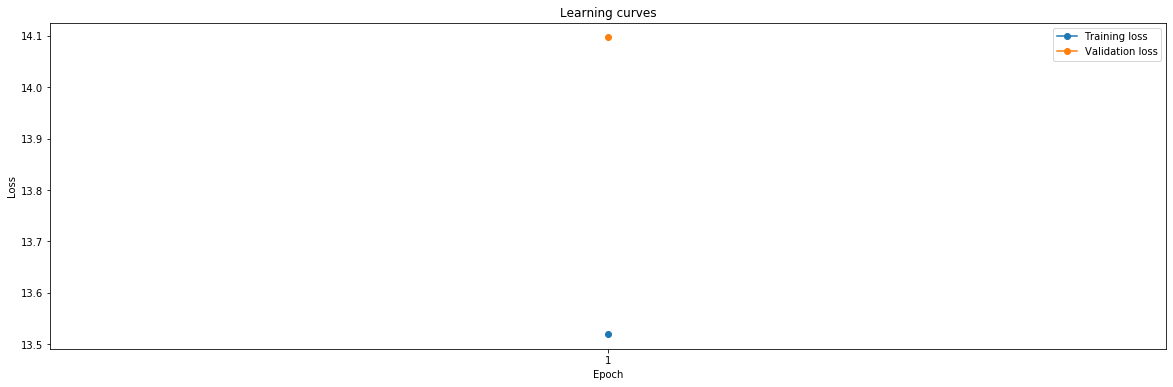

In [0]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(20,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, valid_losses, '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

In [0]:
def simpleGeneratorFun(): 
    yield 1
    yield 2
    yield 3
  
# Driver code to check above generator function 
for value in simpleGeneratorFun():  
    print(value) 

1
2
3
